In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
Image_size=224
Batch_size=32
channel=3
epochs=5

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "Plant Village",
    shuffle=True,
    image_size=(Image_size,Image_size),
    batch_size=Batch_size,
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

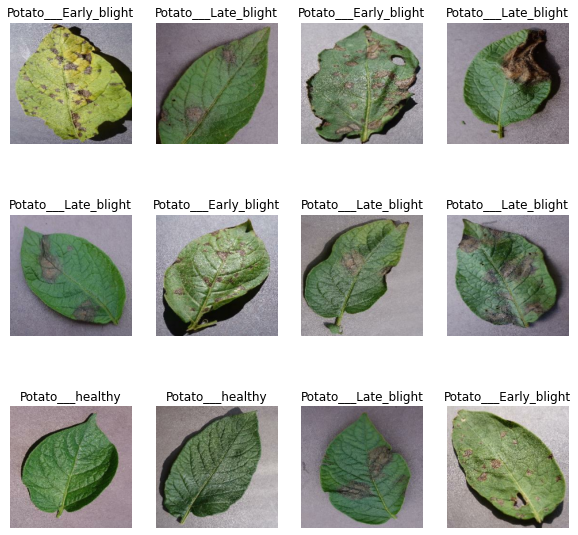

In [5]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [6]:
train_size=0.8
train_ds=dataset.take(54)

In [7]:
val_ds=dataset.skip(54).take(6)
len(val_ds)

6

In [8]:
test_ds=dataset.skip(54).skip(6)
len(test_ds)

8

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
len(train_ds)

54

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(Image_size,Image_size),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [14]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
import tensorflow_hub as hub
extractor="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
pre_model=hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", input_shape=(None,224,224,3),trainable=False)


In [18]:
for image_batch, label_batch in train_ds.take(1):
        print(image_batch[0].numpy().shape)


(224, 224, 3)


In [19]:
input_shape = (Batch_size, Image_size, Image_size, channel)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    pre_model,
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_ds,
    batch_size=Batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=5,
)

Epoch 1/5
54/54 [==============================] - 38s 660ms/step - loss: 0.2522 - accuracy: 0.8993 - val_loss: 0.1548 - val_accuracy: 0.9219
Epoch 2/5
54/54 [==============================] - 33s 613ms/step - loss: 0.0839 - accuracy: 0.9676 - val_loss: 0.1036 - val_accuracy: 0.9635
Epoch 3/5
54/54 [==============================] - 33s 610ms/step - loss: 0.0591 - accuracy: 0.9821 - val_loss: 0.0850 - val_accuracy: 0.9740
Epoch 4/5
54/54 [==============================] - 33s 612ms/step - loss: 0.0491 - accuracy: 0.9815 - val_loss: 0.0677 - val_accuracy: 0.9740
Epoch 5/5
54/54 [==============================] - 33s 613ms/step - loss: 0.0482 - accuracy: 0.9815 - val_loss: 0.0550 - val_accuracy: 0.9688


In [22]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 6s 496ms/step - loss: 0.0294 - accuracy: 0.9883


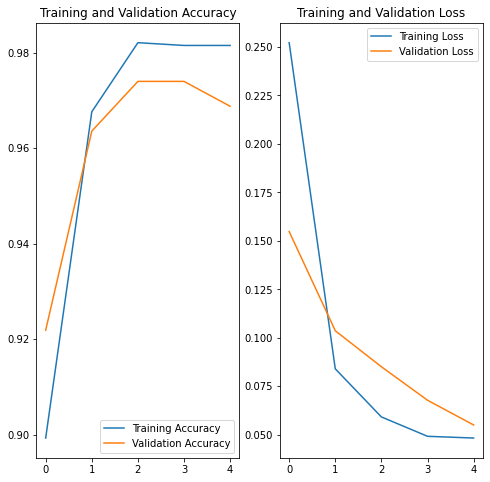

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

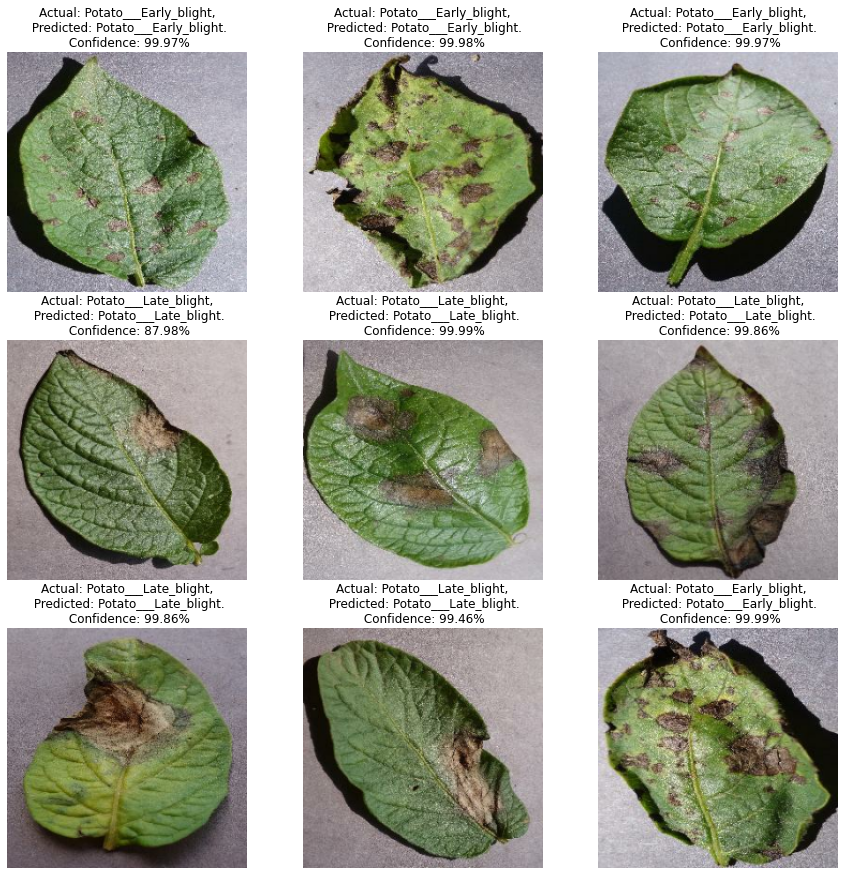

In [27]:
import numpy as np
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")